# Titanic Machine Learning Analysis
## Joshua Hess

This notebook contains my first machine learning analysis with the Titanic dataset. Our goal with this analysis is to create a machine learning model that can predict which passengers survived on the Titanic based on their data. First, let's load in our libraries and our data:

In [49]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# read in data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Glimpse at the training data
print(train.head())

# Aggregate training and testing data
td = pd.concat([train, test], ignore_index = True, sort = False)
print(td.info())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

# Section 1 - Missing Values

The first thing we have to do before beginning our analysis is tidying up our data. Looking at the information above, we can see we have missing values in the `Age`, `Cabin`, `Fare`, and `Embarked` columns. (Note: the missing values in the `Survived` column are from the testing data). Let's deal with each one individually.

## Cabin

We can see that the majority of observations are missing a value for `Cabin`. Imputing values would likely hurt our model due to the lack of data, so we will create a new value `"NA"` for missing values in this column:

In [50]:
# For every missing value, update the Cabin value to "NA"
td.Cabin = td.Cabin.fillna("NA", inplace = True)

## Fare

We only have one missing value in the `Fare` column. Looking at the boxplot of the `Fare` distribution below, the data is highly skewed by extreme values. So we will impute the median of `Fare` in for each missing value:

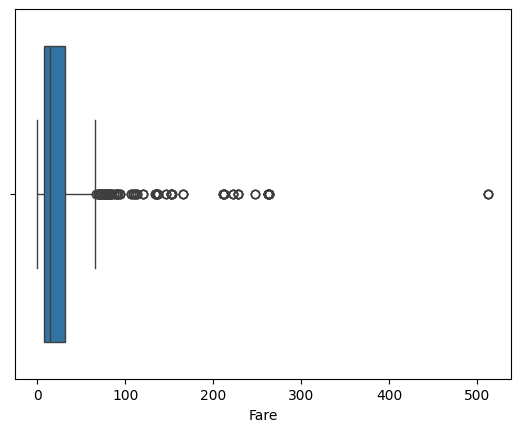

In [51]:
# Check distribution of Fare
sns.boxplot(data = td, x = 'Fare')
plt.show()

# Impute median Fare for each missing value
td['Fare'].fillna(td.Fare.median(), inplace = True)

## Embarked

For the embarked column, we can simply fill in the missing values with the mode of the column, since there are only two missing values:

In [52]:
# Fill NA's with the mode of Embarked
td.Embarked.fillna(td.Embarked.mode()[0], inplace = True)

## Age

For the age column, we have many missing values, about 20% of the dataset. If we look at the boxplots below, we can see that age varies slightly depending on the passenger's class. Let's impute the median age for each class as our substitute values:

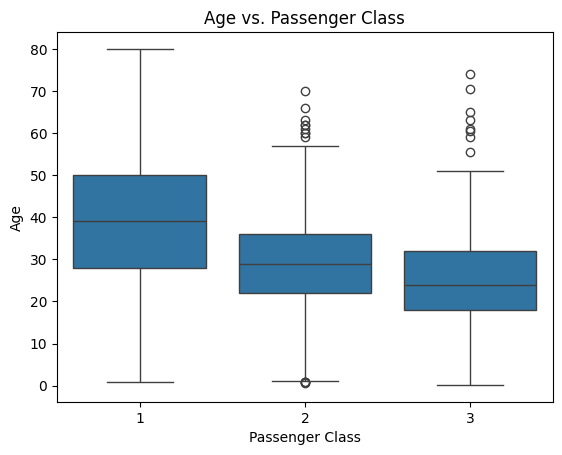

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        0 non-null      object 
 11  Embarked     1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None


In [53]:
# Plot Age by passenger class
sns.boxplot(data = td, x = 'Pclass', y = 'Age')
plt.title("Age vs. Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Age")
plt.show()

# Update each class' age
classes = [1, 2, 3]
for c in classes:
  med = td[td['Pclass'] == c]['Age'].median()
  td.loc[td['Pclass'] == c, 'Age'] = td.loc[td['Pclass'] == c, 'Age'].fillna(med)

# Check for missing values
print(td.info())

# Section 2 - Exploratory Data Analysis

Now that our data is tidy, we can begin some exploratory analysis. The goal of our ML model is to predict which passengers will survive the Titanic disaster. In order to do this, we must determine which features are most predictive of a passenger's survivability. We will start by making some hypotheses about features that could affect a passenger's survival:

- `Sex`: During the Titanic disaster, women evacuated before men did. If a passenger was a woman, we can predict they're more likely to survive.
- `Age`: Similar to women, children were also evacuated before men did. If a passenger was young, we can predict they're more likely to survive.
- `Pclass`: The higher a passenger's class, the more expensive of a ticket they had and the higher room they had on the ship. When the ship began to sink, passengers near the top could evacuate first, so higher class passengers had an advantage. It's likely that higher class passengers were more likely to survive.
- `SibSp` and `Parch`: The higher amount of siblings/parents/children a passenger had, the larger their family was. A family is less likely to be willing to leave without each other, so it's possible that larger families were less likely to survive.

Now we will go feature by feature and explore their correlations (or lack thereof) to `Survived`.

## Sex

Let's start by looking at the proportion of males and females that survived the Titanic:

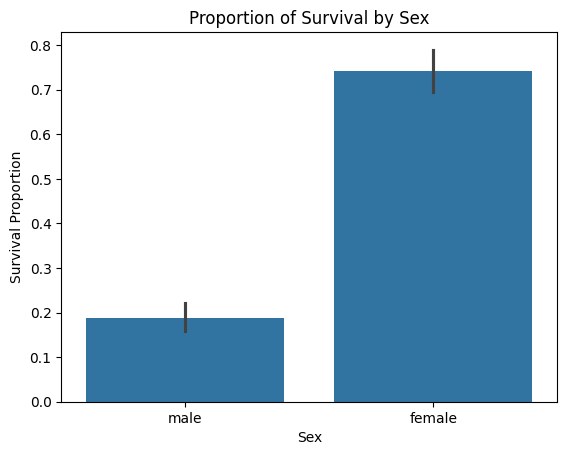

Percentage of males who survived: 12.93%
Percentage of females who survived: 50.00%


In [54]:
# Barplot of Survived vs. Sex
sns.barplot(data = td, x = 'Sex', y = 'Survived')
plt.title("Proportion of Survival by Sex")
plt.ylabel("Survival Proportion")
plt.show()

# Print off proportions of survivors for each sex
for sex in ['male', 'female']:
  total_sex = len(td[td['Sex'] == sex])
  survived_sex = len(td[(td['Sex'] == sex) & (td['Survived'] == 1)])
  proportion = survived_sex / total_sex * 100  # Convert proportion to percentage
  print(f"Percentage of {sex}s who survived: {proportion:.2f}%")

From the above analysis, we can see that there is a stark difference between the survivability of males vs. females. This means that age will be an important feature in our machine learning model.

## Age

Similar to females, children were some of the first passengers to be evacuated. Since age is a continuous variable, let's look at boxplots of the ages for survivors vs. non-survivors:

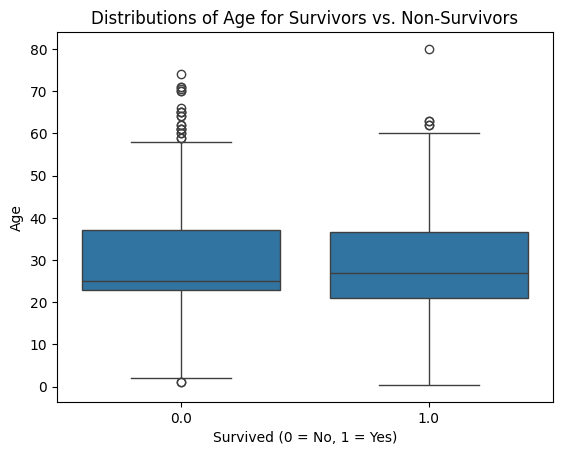

               mean  median       std
Survived                             
0.0       29.618397    25.0  12.81681
1.0       28.355760    27.0  13.99973


In [55]:
# Boxplot of ages for survivors vs. non-survivors
sns.boxplot(data = td, x = 'Survived', y = 'Age')
plt.title("Distributions of Age for Survivors vs. Non-Survivors")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.show()

# Print off summary statistics for age for survivors vs. non-survivors
print(td.groupby('Survived')['Age'].agg(['mean', 'median', 'std']))

Looking at the above boxplots and statistics, we can see that Age actually doesn't have a noticeable correlation with a passenger's survivability. This could partially be due to our data imputation from earlier, so it's important to keep this in mind when creating our model. We can try a couple different models, both with and without Age to see which works better for the testing data.

## Pclass

As we discussed earlier, a passenger's class (1st being the highest, 3rd being the lowest) also has a bearing on where the passenger's cabin was on the ship. 3rd class passengers often had cabins on the lower floors of the ship, while 1st class passengers had cabins on the upper floors. Passengers on the upper floors would have been able to escape more quickly, so let's see if this hypothesis holds up with the data:

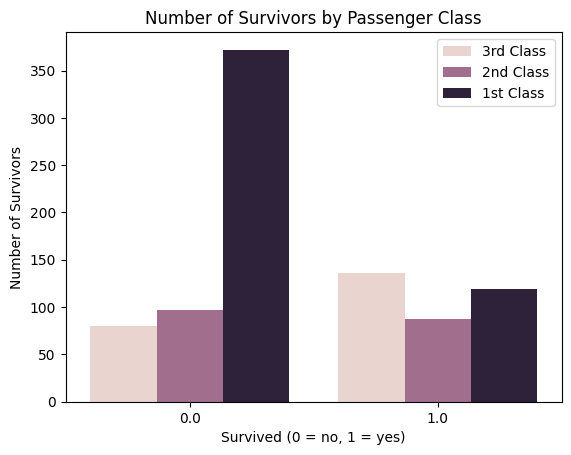

Percentage of Class 1 who survived: 42.11%
Percentage of Class 2 who survived: 31.41%
Percentage of Class 3 who survived: 16.78%


In [56]:
# Count plot of Survived colored by Pclass
sns.countplot(data = td, x = 'Survived', hue = 'Pclass')
plt.title("Number of Survivors by Passenger Class")
plt.xlabel("Survived (0 = no, 1 = yes)")
plt.ylabel("Number of Survivors")
plt.legend(labels = ["3rd Class", "2nd Class", "1st Class"])
plt.show() # TODO: Maybe change the y-axis to show survival proportion?

# Print off survival percentages for each class
for pclass in [1, 2, 3]:
  surv = len(td[(td['Survived'] == 1) & (td['Pclass'] == pclass)])
  total = len(td[td['Pclass'] == pclass])
  percentage = (surv / total) * 100
  print(f"Percentage of Class {pclass} who survived: {percentage:.2f}%")

From the above plot and statistics, we can see that there is a clear difference in survivability for each passenger class. About 42% of 1st class passengers survived, while only about 17% of 1st class passengers survived. Since there is a clear pattern here, we will use `Pclass` in our machine learning model.

## SibSp/Parch

If a passenger boarded the Titanic with a large family, they are less likely to survive because they have more family members to worry about. To test this theory, let's create a new column in the dataset that combines the `SibSp` and `Parch` columns to get a total family size. Then, we'll look at boxplots of the family sizes for survivors vs. non-survivors:

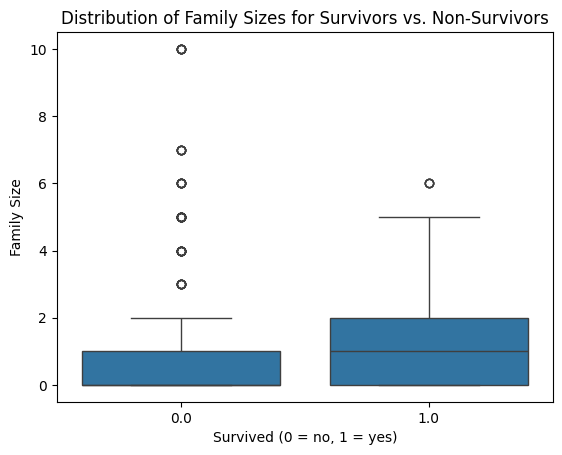

              mean  median       std
Survived                            
0.0       0.883424     0.0  1.830669
1.0       0.938596     1.0  1.186076


In [57]:
# Create "Family" feature by adding SibSp and Parch
td['Family'] = td['SibSp'] + td['Parch']

# Create boxplots of family size for survivors vs. non-survivors
sns.boxplot(data = td, x = 'Survived', y = 'Family')
plt.title("Distribution of Family Sizes for Survivors vs. Non-Survivors")
plt.xlabel("Survived (0 = no, 1 = yes)")
plt.ylabel("Family Size")
plt.show()

# Print off summary statistics for survivors vs. non-survivors
print(td.groupby('Survived')['Family'].agg(['mean', 'median', 'std']))

Looking at the above results, it seems the opposite of our earlier hypothesis may be correct. The non-survivors often had smaller family sizes than the survivors. This could be due to families being prioritized first with the only member staying behind being the father, while individuals were less likely to be prioritized. Regardless, both features will be helpful to our machine learning model.

# Section 3 - Creating Machine Learning Model

For our machine learning model, we need to use a model for a classification problem. We need to classify an observation as a survivor or non-survivor. Based on our analyses above, we will use four features in our model: `Sex`, `Pclass`, `SibSp`, and `Parch`. For our model, we will use a Random Forest classifier with 1000 trees. After creating our model, we'll separate out our training and test data, make our predictions, and output the predictions to a separate CSV file:

In [58]:
# Import Random Forest from Sklearn
from sklearn.ensemble import RandomForestClassifier

y = train["Survived"]

# Get dummies for selected features
features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train[features])
X_test = pd.get_dummies(test[features])

# Create random forest model and store predictions in an array
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

# Output predictions into submission.csv
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
